<a href="https://colab.research.google.com/github/karanprime/DSECOP/blob/main/Gaussian_Processes_and_Schrodinger_Equation/01_Schrodinger_Eqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 Time Independent Schrödinger Equation
Author: Karan Shah

In [ ]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import ipywidgets as widgets
from IPython.display import display

np.random.seed(0)


In this notebook, we will look at the time-indpendent Schrödinger equation (TISE) and solve it numerically with different potentials. This assumes you have gone through the TISE and analyitical solutions for model potentials (eg particle in a box, harmonic oscillator) in your Quantum Mechanics course. We will use the code written here to generate data for the subsequent notebooks.  Fill in the `None` values in code blocks beginning with `# Exercise`.

## Brief Background
The Time-Independent Schrödinger Equation is a fundamental equation in quantum mechanics that describes how the quantum state of a physical system changes in space, but not in time. It is derived from the more general Time-Dependent Schrödinger Equation (TDSE) under the assumption that the system is in a steady state, meaning the potential energy within the system does not change with time. The TISE is crucial for understanding the behavior of particles in potential wells, quantum tunneling, and the quantization of energy levels in atoms and molecules.

### Mathematical Formulation

The Time-Independent Schrödinger Equation can be introduced starting from the fundamental relationship involving the Hamiltonian operator $ \hat{H} $ acting on the wave function $ \psi $, equating it to the energy $ E $ of the system times the wave function. This is expressed as:

$$
\hat{H} \psi = E \psi
$$

The Hamiltonian operator $ \hat{H} $ represents the total energy of the system and is composed of the kinetic energy ($ T $) and potential energy ($ V $) operators:

$$
\hat{H} = \hat{T} + \hat{V}
$$

where the kinetic energy operator $ \hat{T} $ is given by:

$$
\hat{T} = -\frac{\hbar^2}{2m} \nabla^2
$$

and $ \hat{V} $ represents the potential energy operator, which in position space is simply multiplication by the potential energy function $ V(\mathbf{r}) $:

$$
\hat{V} = V(\mathbf{r})
$$

Substituting the expressions for $ \hat{T} $ and $ \hat{V} $ into the Hamiltonian, we obtain the Time-Independent Schrödinger Equation in position space:

$$
\left( -\frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r}) \right) \psi(\mathbf{r}) = E\psi(\mathbf{r})
$$

Here:
- $ \hbar $ is the reduced Planck's constant ($ \hbar = \frac{h}{2\pi} $),
- $ m $ is the mass of the particle,
- $ \nabla^2 $ is the Laplacian operator, indicating the second spatial derivatives,
- $ \psi(\mathbf{r}) $ is the wave function of the particle, a complex function that provides information about the probability amplitude of the particle's position,
- $ V(\mathbf{r}) $ is the potential energy as a function of position,
- $ E $ is the total energy of the system, which is a constant for time-independent systems.

### Physical Interpretation

The Time-Independent Schrödinger Equation is an eigenvalue equation where the eigenvalues $ E $ correspond to the energy levels of the system, and the eigenfunctions $ \psi(\mathbf{r}) $ represent the stationary states. The probability density of finding the particle at a given position $ \mathbf{r} $ is given by the square modulus of the wave function, $ |\psi(\mathbf{r})|^2 $.


## Problem Setup

We want to solve the Schrödinger equation in 1D for a single particle system. We will use atomic units use atomic units unless specified: $\hbar=m=e=1$. In this case, we are solving the following eigenvalue problem:

$$
\left( -\frac{1}{2} \frac{d^2}{dx^2} + V(x) \right) \psi(x) = E\psi(x)
$$

The wavefuntion $\psi$ is the eigenvector and $E$ is the eigenvalue.

### Discretization of the Spatial Domain

First, we discretize the spatial domain into a grid of points. Let's choose $N$ points $x_i$ where $i = 0, 1, ..., N-1$ along the $x$-axis, with a uniform spacing $h = \frac{x_{max} - x_{min}}{N-1}$ between them. The points are thus given by $x_i = x_{min} + i \cdot h$. Let's implement this from the formulae in this section:


In [ ]:
x_min, x_max = 0, 10
N = 11

# Exercise: calculate the grid spacing using the equation
h_equation = None
x_grid_equation = np.zeros(N)

for i in range(N):
    # use x_min, i and h_equation to get your grid
    x_grid_equation[i] = None

print("Using the equation:")
print(f"x_grid = {x_grid_equation}")
print(f"h = {h_equation}")


Using the equation:
x_grid = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
h = 1.0


We can use the inbuilt `np.linspace()` function to get this grid. Look at the documentation and get a grid `[0, 1, 2, ..., 10]` and $h$ value by completing the following code cell.

In [ ]:
# Exercise: Use linspace to make the grid, make sure to check the documentation and use the correct retstep argument.
x_grid, h = None

print("Using numpy's linspace:")
print(f"x_grid = {x_grid}")

print("Does the grid spacing match the equation?", h == h_equation)
print("Are the grids the same?", np.all(x_grid == x_grid_equation))



Using numpy's linspace:
x_grid = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Does the grid spacing match the equation? True
Are the grids the same? True




### Finite Difference Approximation
We take a short detour to study a simple numerical method to get the derivates. It is called the Finite Difference Method.

We know that first derivative of a function $f(x)$ at a point $x$ represents the rate at which $f(x)$ changes with respect to $x$. The first derivative is defined as the limit of the average rate of change of the function as the interval over which the change is measured approaches zero. Mathematically, this is expressed as:

$$
f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$

where $h$ is the difference between the neighboring point $x+h$ and the point $x$, and $f(x+h) - f(x)$ represents the change in the function's value over that interval. The expression $\frac{f(x+h) - f(x)}{h}$ calculates the average rate of change of $f(x)$ over the interval from $x$ to $x+h$.

The approximation of the first derivative works based on the principle of this definition. In practice, we cannot take the limit as $h$ goes to zero because that would require infinitesimally small steps, which are not possible to handle with numerical computations. Instead, we choose a small but finite value of $h$, which allows us to approximate the instantaneous rate of change (the derivative) by calculating the slope of the secant line that passes through the points $(x, f(x))$ and $(x+h, f(x+h))$.

So, we have
$$
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_i)}{h}
$$

for a finite $h$. This formula gives a first-order approximation of the derivative.

Let's implement this in python for an arbitrary function `f` at grid points `x_grid`


In [ ]:
# Exercise: Get the first derivative numerically
def approximate_first_derivative(f, x_grid):
    dfdx = np.zeros_like(x_grid)

    # Compute the spacing based on the input grid
    # Assuming uniform spacing
    h = None

    # Forward difference for all points except the last
    dfdx[:-1] = None

    # This is provided to make sure that the last point is not left out.
    # Since we don't have a forward difference for the last point, we'll use a backward difference.
    # It is similar to the forward difference, but we use the previous point instead of the next point.
    dfdx[-1] = (f(x_grid[-1]) - f(x_grid[-2])) / h

    return dfdx

In [ ]:
def test_derivative(k):
    x_min = 0
    x_max = 10
    N = (x_max - x_min)/10**k + 1
    x = np.linspace(0, 10, int(N))

    f = np.sin

    dfdx_approx = approximate_first_derivative(f, x)

    dfdx_exact = np.cos(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, dfdx_approx, label='FDM Derivative', marker='o', linestyle='--')
    plt.plot(x, dfdx_exact, label='Analytical Derivative', alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('df/dx')
    plt.title(f'Approximation vs. Analytical Derivative of $f(x) = sin(x)$, h = {x[1]-x[0]}')
    plt.legend()
    plt.show()

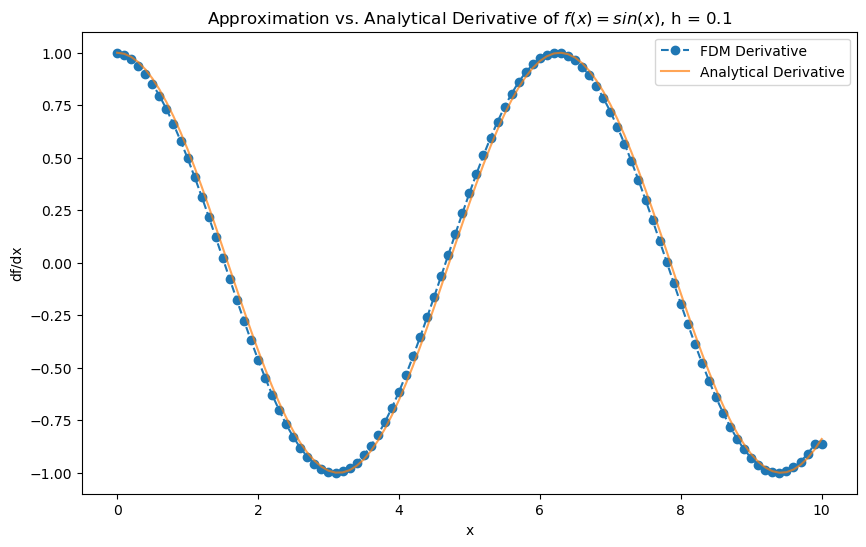

In [ ]:
test_derivative(-1)

The following widget shows the effect of varying $h$ on the quality of the approximation. As you can see, for very high values of $h$ (sparse grid), the derivative is not very accurate. It gets more accurate as $h$ decreases. The slider controls value $k$, where $h=10^k$.

In [ ]:
k_exp_slider = widgets.FloatSlider(value=-2, min=-4, max=1, step=-1, description='k')

interactive_plot = widgets.interactive(test_derivative, k=k_exp_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=-2.0, description='k', max=1.0, min=-4.0, step=-1.0), Output()), _dom_…

To approximate the second derivative, we start from the basic first derivative approximations and extend them. The second derivative at a point $x_i$ can be derived by applying the first derivative approximation twice, leading to:

$$
f''(x_i) \approx \frac{f'(x_{i+1}) - f'(x_i)}{h}
$$

Exercise: Use the forward difference formula for $f'(x_{i+1})$ and $f'(x_i)$ and simplify the above equation to get:

$$
f''(x_i) \approx \frac{f(x_{i+1}) - 2f(x_i) + f(x_{i-1})}{h^2}
$$

This gives us a second-order accurate approximation of the second derivative.

Notice that x grid is a vector of length $N+1$. We can represent this as a matrix multiplication

$$
F2X = FD2 * f(x)
$$
where f(x) is the vector of legth $N+1$, and FD2 is a matrix of shape $N+1, N+1$ with diagonal elements corresponding to the terms in the finite difference equation you derived above. Let's implement this in code:

In [ ]:
# Exercise

def get_fd2_matrix(x_grid, fix_boundary=False):
    # Define the matrix
    N = len(x_grid)
    h = x_grid[1] - x_grid[0]

# Main diagonal values (central differences for the second derivative)
    main_diagonal = None

    # Off diagonal values (one step off the main diagonal)
    off_diagonal = None

    # Assemble the tridiagonal matrix
    fd_matrix = np.diag(main_diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)

    # These are for numerical stability. We use higher order terms at the boundaries.
    if fix_boundary:
        if N > 4:
            fd_matrix[0, :4] =  [2, -5, 4, -1] / h**2
            fd_matrix[-1, -4:] = [-1, 4, -5, 2] / h**2
        else:
            raise ValueError("The grid is too small to use higher order terms.")

    return fd_matrix


This is what the matrix looks like:

In [ ]:
mat = get_fd2_matrix(np.arange(0,5,1)/1)
print(mat)

[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


Do you notice the [1, -2, 1] pattern from our derivation?

Now we use this matrix on our test problem sin(x)

In [ ]:
def test_second_derivative(k, show_boundary=False, fix_boundary=False):
    x_min = 0
    x_max = 6.28
    N = (x_max - x_min)/10**k + 1
    x = np.linspace(x_min, x_max, int(N))

    f = np.sin(x)
    mask = np.arange(len(x))

    if not show_boundary:
        mask = mask[1:-1]

    fd_matrix = get_fd2_matrix(x, fix_boundary=fix_boundary)

    df2dx2_approx = fd_matrix @ f


    dfdx_exact = -np.sin(x)
    # print(f"{k=}, {show_boundary=}")
    plt.figure(figsize=(10, 6))
    plt.plot(x[mask], df2dx2_approx[mask], label='FDM Derivative', marker='o', linestyle='--')
    plt.plot(x[mask], dfdx_exact[mask], label='Analytical Derivative', alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('df/dx')
    plt.title(f'Approximation vs. Analytical Derivative of $f(x) = sin(x)$, h = {x[2]-x[1]:.3}, 10^k={10**k}')
    plt.legend()
    plt.show()

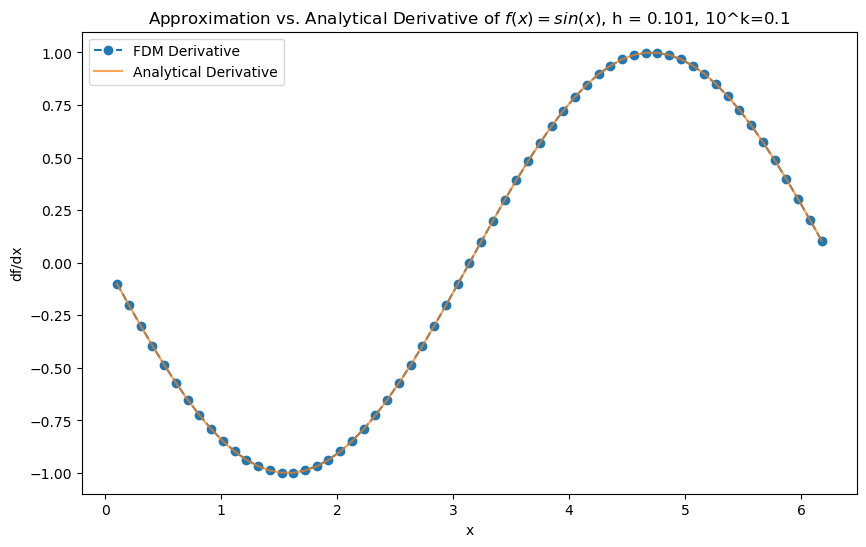

In [ ]:
test_second_derivative(-1)

In [ ]:
show_boundary_checkbox = widgets.Checkbox(value=False, description='Show Boundary')
fix_boundary_checkbox = widgets.Checkbox(value=False, description='Fix Boundary')
k_exp_slider = widgets.FloatSlider(value=-2, min=-3, max=0, step=-1, description='k')

interactive_plot = widgets.interactive(test_second_derivative, k=k_exp_slider, show_boundary=show_boundary_checkbox, fix_boundary=fix_boundary_checkbox)
display(interactive_plot)

interactive(children=(FloatSlider(value=-2.0, description='k', max=0.0, min=-3.0, step=-1.0), Checkbox(value=F…

Notice that the value of $h$ is not always equal to $10^k$.
Another issue is calculating the derivative at boundaries. Toggle the "Show Boundary" check box. You will see that the approximation blows up at boundaries. We need to be careful while designing numerical methods to avoid these numerical issues.

Now toggle the "Fix Boundary" check box. It fixes the derivative at boundaries. Revisit the `get_fd2_matrix` function and look at the fix_boundary code. What do you observe? Instead of using `[-1, -2, -1]` terms that we got from our FDM derivation, we are using `[2, -5, 4, -1]` and `[-1, 4, -5, 2]` at `x_min` and `x_max` respectively. These can be derived by using higher order terms. You can read about it in more detail here:


### Setting up TISE solver

The second derivative in the kinetic energy term can be approximated using the central difference formula:
$$
\frac{d^2\psi}{dx^2} \bigg|_{x_i} \approx \frac{\psi(x_{i+1}) - 2\psi(x_i) + \psi(x_{i-1})}{h^2}
$$

Substituting this into the TISE, we get a discrete version:
$$
-\frac{1}{2} \frac{\psi(x_{i+1}) - 2\psi(x_i) + \psi(x_{i-1})}{h^2} + V(x_i)\psi(x_i) = E\psi(x_i)
$$

This leads to a system of linear equations that can be represented in matrix form as $H\vec{\psi} = E\vec{\psi}$, where $H$ is a tridiagonal matrix with the diagonal elements given by $\left(\frac{1}{h^2} + V(x_i)\right)$ and the off-diagonal elements by $-\frac{1}{2h^2}$.

Now this eigenvalue problem can be solved by matrix inversion methods that you learnt about in your Linear Algebra course. We will use the built-in `np.linalg.eigh` function to get the eigenvalues and eigenvectors. The function takes a potential function `V` and its `params`.

In [ ]:
# Utility: Normalize wavefunction

def normalize_wavefunction(psi, x):
    density = np.conj(psi) * psi
    integral_density = np.trapz(density, x)
    return psi/np.sqrt(integral_density)



In [ ]:
# Exercise: Use the functions we defined to set up a TISE solver
def solve_tise(V, params, x_min, x_max, N, state_n=0):
    # Discretize the spatial domain
    x = np.linspace(x_min, x_max, N)

    # Evaluate the potential energy
    V_x = V(x, params)

    # Assemble the Hamiltonian matrix
    T_mat = get_fd2_matrix(x)
    V_mat = np.diag(V_x)

    H_mat = None

    # Solve the eigenvalue problem
    E, psi = np.linalg.eigh(H_mat)
    E = E[state_n]
    psi = psi[:, state_n]

    # Normalize the wavefunction
    psi = normalize_wavefunction(psi, x)

    return x, E, psi


In [ ]:
# Utility: Plotting the wavefunction
def wavefunction_plotter(V, params, x_min, x_max, N, state_n=0, true_wavefunction_fn=None, true_energy_fn=None, sys_name="System"):
    x, E, psi = solve_tise(V, params, x_min, x_max, N, state_n)
    if true_wavefunction_fn is not None and true_energy_fn is not None:
            true_E = true_energy_fn(state_n, params)
            true_wfs = true_wavefunction_fn(x, state_n, params)

            # Normalize the wavefunction
            true_density = np.conj(true_wfs) * true_wfs
            integral_density = np.trapz(true_density, x)
            true_wfs = true_wfs/ np.sqrt(integral_density)


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 9))

    ax1.plot(x, psi, label=f'E_{state_n} = {E:.2f}')
    if true_wavefunction_fn is not None and true_energy_fn is not None:
        ax1.plot(x, true_wfs, label=f'True E_{state_n} = {true_E:.2f}', linestyle='--')
    ax1_right = ax1.twinx()
    ax1_right.plot(x, V(x, params), label='V(x)', color='black')
    ax1_right.set_ylabel('V(x)')
    ax1.set_xlabel('x')
    ax1.set_ylabel(r'$\psi(x)$')
    ax1.set_title(f'Wavefunction for {sys_name}, state {state_n}')
    ax1.legend(loc='upper left')
    ax1_right.legend(loc='upper right')

    density = np.conj(psi) * psi

    ax2.plot(x, density, label=r'Density |$\psi$|^2')

    if true_wavefunction_fn is not None and true_energy_fn is not None:
        ax2.plot(x, true_density, label=r'True Density |$\psi$|^2', linestyle='--')
    ax2_right = ax2.twinx()
    ax2_right.plot(x, V(x, params), color='black')
    ax2_right.set_ylabel('V(x)')
    ax2.set_xlabel('x')
    ax2.set_ylabel(r'|$\psi(x)$|^2')
    ax2.set_title(f'Density for {sys_name}, state {state_n}')
    ax2.legend(loc='upper left')
    ax2_right.legend(loc='upper right')

    plt.tight_layout()
    plt.show()




## Potentials
Now that we have our solver set up, let us generate solutions for different types of potentials.


### Ininite square well
The infinite square well (or particle in a box) is a fundamental quantum mechanical system that provides profound insights into the quantization of energy. In this model, a particle is confined to a one-dimensional box with infinitely high walls, leading to discrete energy levels. The potential $V(x)$ can be described as:

$$
V(x) = \begin{cases}
0, & \text{if } 0 \leq x \leq L\\
\infty, & \text{otherwise}
\end{cases}
$$

where $L$ is the width of the well. For the region inside the well ($0 \leq x \leq L$), the TISE simplifies to:

$$
-\frac{1}{2} \frac{d^2}{dx^2} \psi(x) = E\psi(x)
$$

#### Analytical Solution

The boundary conditions dictate that $\psi(x) = 0$ at $x = 0$ and $x = L$, leading to quantized energy levels. The solutions to the TISE in this case are sinusoidal functions inside the well:

$$
\psi_n(x) = \sqrt{\frac{2}{L}} \sin\left(\frac{n\pi x}{L}\right), \quad n = 1, 2, 3, \ldots
$$

The corresponding energy levels are given by:

$$
E_n = \frac{n^2\pi^2}{2L^2}, \quad n = 1, 2, 3, \ldots
$$

Let us implement the potential and analytical solution:

In [ ]:
# Exercise

def V_infinite_well(x, params):
    L = params
    psi = None
    return psi

def analytical_eigenvalues_infinite_well(n, params):
    n = n + 1 # avoiding trivial solution
    L = params
    E = None
    return E

def analytical_eigenfunctions_infinite_well(x, n, params):
    n = n + 1 # avoiding trivial solution
    L = params
    psi = None
    return normalize_wavefunction(psi, x)

Now let us solve it with our numerical solver:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


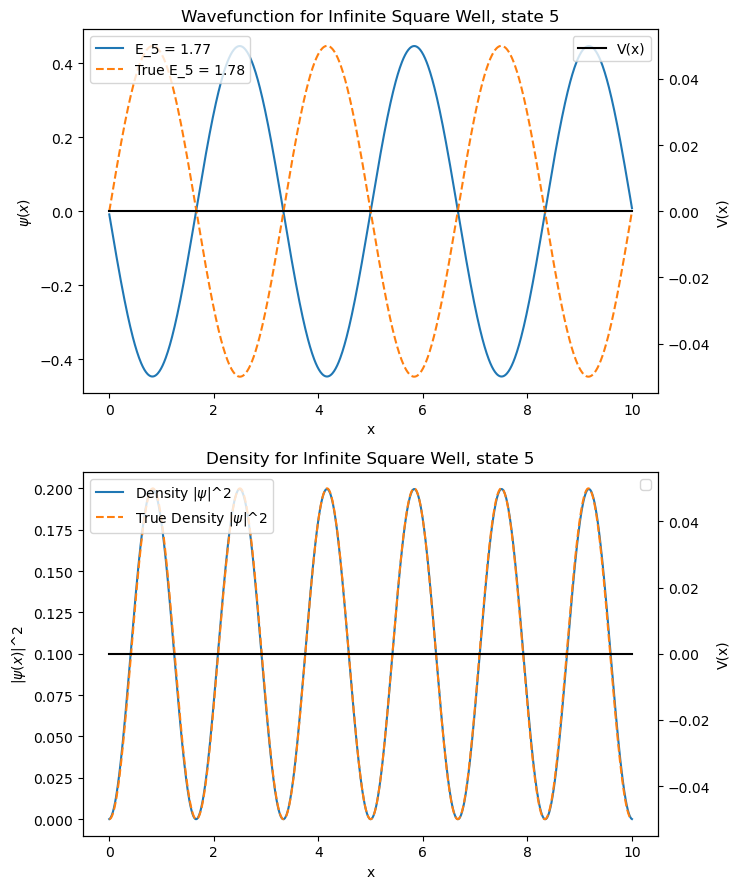

In [ ]:
L = 10
x_min = 0
x_max = L
N = 1001
V = V_infinite_well
params = L
n_state = 5
true_wavefunction_fn=analytical_eigenfunctions_infinite_well
true_energy_fn=analytical_eigenvalues_infinite_well
sys_name = "Infinite Square Well"

wavefunction_plotter(V, params, x_min, x_max, N, n_state, true_wavefunction_fn=true_wavefunction_fn, true_energy_fn=true_energy_fn, sys_name=sys_name)

In [ ]:
state_n_slider = widgets.IntSlider( value=0, min=0, max=10, step=1, description='state_n:', continuous_update=False)

def interactive_wavefunction_plotter(state_n):
    wavefunction_plotter(V, params, x_min, x_max, N, state_n, true_wavefunction_fn, true_energy_fn, sys_name)

interactive_plot = widgets.interactive(interactive_wavefunction_plotter, state_n=state_n_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, continuous_update=False, description='state_n:', max=10), Output()), …

### Quantum Harmonic Oscillator

The quantum harmonic oscillator models a particle moving under a restoring force proportional to its displacement from a equilibrium position, akin to a mass on a spring. The potential energy $V(x)$ of the QHO is given by:

$$
V(x) = \frac{1}{2}\omega^2x^2
$$

where $m$ is the mass of the particle, $\omega$ is the angular frequency of the oscillator, and $x$ is the displacement from equilibrium. In quantum mechanics, the TISE for the harmonic oscillator becomes:

$$
\left( -\frac{1}{2} \frac{d^2}{dx^2} + \frac{1}{2}\omega^2x^2 \right) \psi(x) = E\psi(x)
$$

#### Analytical Solution

The solutions to the quantum harmonic oscillator are Hermite polynomials multiplied by a Gaussian exponential. The energy eigenvalues are given by:

$$
E_n = \left(n + \frac{1}{2}\right)\omega, \quad n = 0, 1, 2, \ldots
$$

The analytical solution $\psi(x,t) \in \mathbb{C}$ is
$$
\psi_0(x) = \sqrt[4]{\frac{\omega}{\pi}}e^{\left(-\frac{\omega x^2}{2}\right)}
$$
and
$$
\psi_n(x) = \psi_0(x) \frac{1}{\sqrt{2^n n!}}Her_n(\sqrt{\omega}x)
$$
where $Her_n$ are the Hermite polynomials of degree $n$.

Let us implement the potential:

In [ ]:
# Exercise
def V_harmonic_oscillator(x, params):
    omega = params
    v = 0.5 * omega**2 * x**2
    return v

To implement the analytical solution, we need to first implement Hermite polynomials. We will use the recursive definition:
- $H_0(x) = 1$
- $H_1(x) = 2x$
- $H_{n+1}(x) = 2xH_n(x) - 2nH_{n-1}(x)$ for $n \geq 1$

Let's implement this recursive definition:

In [ ]:
# Exercise: Use the above recursive relation to calculate the Hermite polynomials
def hermite_polynomial(n, x):

    if n == 0:
        return None
    elif n == 1:
        return None
    else:
        return None


In [ ]:
# Exercise
def analytical_eigenvalues_harmonic_oscillator(n, params):

    omega = params
    E = None
    return E

def analytical_eigenfunctions_harmonic_oscillator(x, n, params):

    omega = params

    psi_0 = None

    if n > 0:
        prefactor = None
        hermite_polynomial_n = hermite_polynomial(n, np.sqrt(omega) * x)
        psi = prefactor * hermite_polynomial_n * psi_0
        return normalize_wavefunction(psi, x)
    else:
        return normalize_wavefunction(psi_0, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


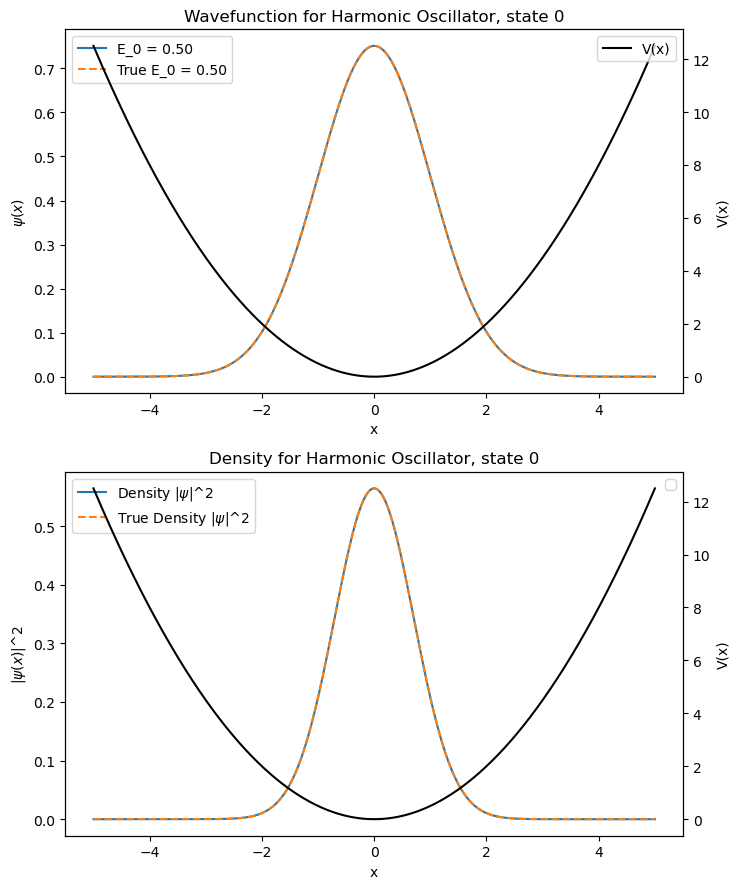

In [ ]:
wavefunction_plotter(V_harmonic_oscillator, 1, -5, 5, 1001, 0, analytical_eigenfunctions_harmonic_oscillator, analytical_eigenvalues_harmonic_oscillator, "Harmonic Oscillator")

In [ ]:
omega = 5
x_min = -np.pi
x_max = np.pi
N = 1001
V = V_harmonic_oscillator
params = omega
state_n = 0
true_wavefunction_fn = analytical_eigenfunctions_harmonic_oscillator
true_energy_fn = analytical_eigenvalues_harmonic_oscillator
sys_name = "Harmonic Oscillator"

state_n_slider = widgets.IntSlider( value=0, min=0, max=10, step=1, description='state_n:', continuous_update=False)

def interactive_wavefunction_plotter(state_n):
    wavefunction_plotter(V, params, x_min, x_max, N, state_n, true_wavefunction_fn, true_energy_fn, sys_name)

interactive_plot = widgets.interactive(interactive_wavefunction_plotter, state_n=state_n_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, continuous_update=False, description='state_n:', max=10), Output()), …

As is clear from the plots, the numerically calculated wavefunctions and energies closely match the true analytically calculated ones. For some states, there might be shift of phase in wavefunctions. This validates our numerical code and we can move on to a potential without any analytical solution.

### Double-well Inverted Gaussian

The double-well inverted Gaussian potential is a more complex system compared to the infinite square well or the quantum harmonic oscillator. It represents a scenario where a particle can exist in one of two potential minima, separated by a potential barrier. This setup is particularly interesting for studying tunneling effects and bistability in quantum mechanics. Unlike the previous examples, the double-well inverted Gaussian does not have simple analytical solutions for its energy eigenstates and eigenvalues, making numerical methods especially valuable.

The potential can be modeled as an inversion of a Gaussian function, creating two wells with a barrier in the middle. A typical form of the potential is:

$$
V(x) = -A_1 e^{-\frac{(x-x_1)^2}{2\sigma_1^2}} - A_2 e^{-\frac{(x+x_2)^2}{2\sigma_2^2}}
$$

where $V_0$ is the depth of the wells, $x_0$ is the displacement of each well from the center, and $\sigma$ controls the width of the wells.

There is no closed-form solution in this case. We validated our numerical solver with analytical solution in the previous cases, and will use it to get the solution.

Let's define the potential function for the double-well inverted Gaussian and solve it numerically. Since there aren't simple analytical solutions for general parameters, we'll focus on the numerical approach.

In [ ]:
# Exercise
def V_double_well(x, params):
    A1, A2, x1, x2, sigma1, sigma2 = params
    V = None
    return V


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


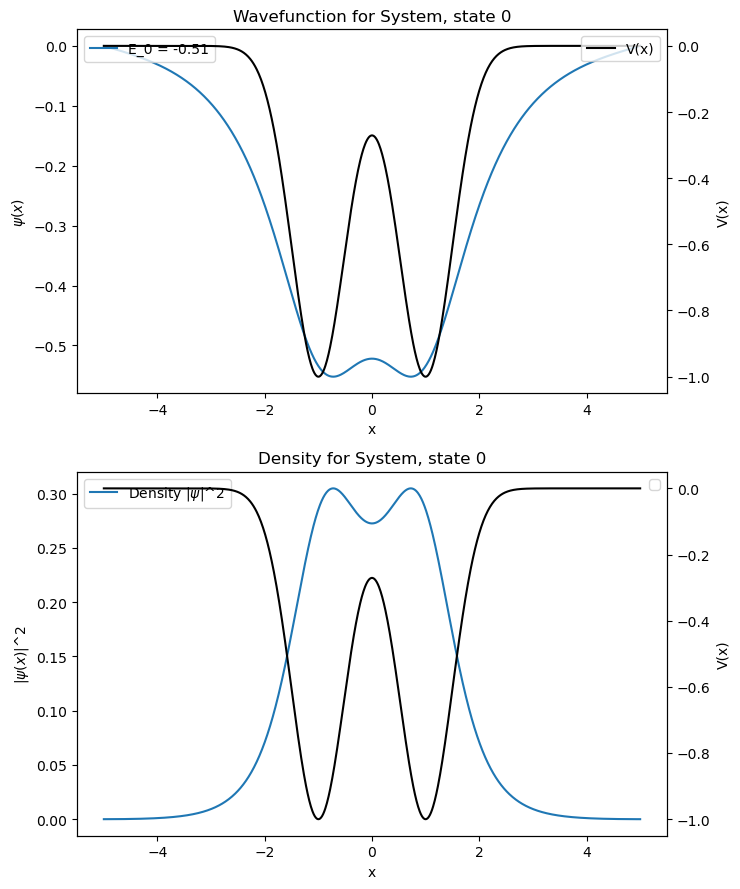

In [ ]:
wavefunction_plotter(V_double_well, [1, 1, -1, 1, 0.5, 0.5], -5, 5, 1001, 0)

In [ ]:
x_min = -8
x_max = 8

A1 = 1
A2 = A1
x1 = -2
x2 = -x1
sigma1 = 1
sigma2 = 1

N = 1001
V = V_double_well
params = [A1, A2, x1, x2, sigma1, sigma2]
state_n = 0
true_wavefunction_fn = None
true_energy_fn = None
sys_name = "Double Inverted Gaussian"

state_n_slider = widgets.IntSlider( value=0, min=0, max=10, step=1, description='state_n:', continuous_update=False)

def interactive_wavefunction_plotter(state_n):
    wavefunction_plotter(V, params, x_min, x_max, N, state_n, true_wavefunction_fn, true_energy_fn, sys_name)

interactive_plot = widgets.interactive(interactive_wavefunction_plotter, state_n=state_n_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, continuous_update=False, description='state_n:', max=10), Output()), …

### Conclusion

In this notebook, we began with an introduction to the TISE. Then we built up a numerical solver, learning about Finite Differences and python eigenvalue solvers. We then implemented various model potentials and compared their analytical solutions with the solutions from our numerical solver. We will use this knowledge to generate systems with varying potential parameters in notebook 3, where our task is to use a Gaussian Process to predict the ground state energy from the potential.